# LegacyHalos Sample Selection

The goal of this notebook is to select our parent sample of central and satellite galaxies with Legacy Survey DR6+DR7 photometry.

The input (row-matched) catalogs for the centrals are:
* $REDMAPPER_DIR/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog.fit  

* $REDMAPPER_DIR/v6.3.1/redmapper-v6.3.1-lgt5-centrals-sdssWISEphot-dr14.fits (generated by [redmapper-sdssWISEphot.ipynb](https://github.com/moustakas/legacyhalos/tree/master/doc/redmapper-sdssWISEphot.ipynb))  

* $REDMAPPER_DIR/v6.3.1/legacysurvey-dr6-dr7-centrals-v6.3.1.fits (generated by [match-legacysurvey-redmapper.slurm](https://github.com/moustakas/legacyhalos/tree/master/bin/match-legacysurvey-redmapper.slurm))  

and for the satellites:
* $REDMAPPER_DIR/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog_members.fit

* $REDMAPPER_DIR/v6.3.1/redmapper-v6.3.1-lgt5-members-sdssWISEphot-dr14.fits (generated by [redmapper-sdssWISEphot.ipynb](https://github.com/moustakas/legacyhalos/tree/master/doc/redmapper-sdssWISEphot.ipynb))  

* $REDMAPPER_DIR/v6.3.1/legacysurvey-dr6-dr7-members-v6.3.1.fits (generated by [match-legacysurvey-redmapper.slurm](https://github.com/moustakas/legacyhalos/tree/master/bin/match-legacysurvey-redmapper.slurm))

And the resulting output catalogs are the files:

* $LEGACYHALOS_DIR/sample/legacyhalos-centrals-dr6-dr7.fits

* $LEGACYHALOS_DIR/sample/legacyhalos-satellites-dr6-dr7.fits

In addition, we create jackknife subsamples of the data and write them out in the file:

* $LEGACYHALOS_DIR/sample/legacyhalos-jackknife-dr6-dr7.fits

### Imports

In [1]:
import os, warnings
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import healpy as hp
import fitsio
from astropy.io import fits
from astropy.table import Table, Column, vstack, hstack, join
import astropy.units as u
from astropy.coordinates import SkyCoord

In [3]:
import legacyhalos.io
from legacyhalos.misc import radec2pix, pix2radec

In [4]:
import seaborn as sns
%matplotlib inline

### Specify the LegacyHalos path and output files names.

In [5]:
legacyhalos_dir = os.getenv('LEGACYHALOS_DIR')
if not os.path.exists(legacyhalos_dir):
    os.makedirs(legacyhalos_dir)

In [6]:
lsdr, sdssdr, rmversion = 'dr6-dr7', 'dr14', 'v6.3.1'

In [7]:
cenfile = os.path.join( legacyhalos.io.sample_dir(), 'legacyhalos-centrals-{}.fits'.format(lsdr) )
satfile = os.path.join( legacyhalos.io.sample_dir(), 'legacyhalos-satellites-{}.fits'.format(lsdr) )
jackfile = os.path.join( legacyhalos.io.sample_dir(), 'legacyhalos-jackknife-{}.fits'.format(lsdr) )

### Read the matched Legacy Survey and redMaPPer catalogs.

In [8]:
def read_legacysurvey(lsdr='dr6-dr7', rmversion='v6.3.1', index=None, satellites=False):
    """Read the matched Legacy Survey catalog.
    
    Note that non-matching entries are populated with zeros / False.
    
    """
    if satellites:
        galtype = 'members'
    else:
        galtype = 'centrals'
    lsfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                           'legacysurvey-{}-{}-{}-lgt5.fits'.format(lsdr, galtype, rmversion) )
    ls = Table(fitsio.read(lsfile, ext=1, upper=True, rows=index))
    print('Read {} galaxies from {}'.format(len(ls), lsfile))

    return ls

In [9]:
def read_redmapper(rmversion='v6.3.1', index=None, satellites=False):
    """Read the parent redMaPPer cluster catalog and updated photometry.
    
    """
    if satellites:
        suffix1, suffix2 = '_members', '-members'
    else:
        suffix1, suffix2 = '', '-centrals'
    rmfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                          'dr8_run_redmapper_{}_lgt5_catalog{}.fit'.format(rmversion, suffix1) )
    rmphotfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                          'redmapper-{}-lgt5{}-sdssWISEphot-{}.fits'.format(rmversion, suffix2, sdssdr) )
    
    rm = Table(fitsio.read(rmfile, ext=1, upper=True, rows=index))
    rmphot = Table(fitsio.read(rmphotfile, ext=1, upper=True, rows=index))
    print('Read {} galaxies from {}'.format(len(rm), rmfile))
    print('Read {} galaxies from {}'.format(len(rmphot), rmphotfile))
    
    rm.rename_column('RA', 'RA_REDMAPPER')
    rm.rename_column('DEC', 'DEC_REDMAPPER')
    rmphot.rename_column('RA', 'RA_SDSS')
    rmphot.rename_column('DEC', 'DEC_SDSS')
    rmphot.rename_column('OBJID', 'SDSS_OBJID')

    if satellites:
        rmout = join(rmphot, rm, join_type='left', keys=['ID', 'MEM_MATCH_ID'])
    else:
        rmout = join(rmphot, rm, join_type='left', keys='MEM_MATCH_ID')

    # Add a central_id column
    #rmout.rename_column('MEM_MATCH_ID', 'CENTRAL_ID')
    cid = ['{:07d}'.format(cid) for cid in rmout['MEM_MATCH_ID']]
    rmout.add_column(Column(name='CENTRAL_ID', data=cid, dtype='U7'), index=0)
    
    return rmout

### Centrals
#### Require a match with redMaPPer and non-zero depth in all three bands.

In [10]:
lscenall = read_legacysurvey(lsdr=lsdr, rmversion=rmversion)

Read 396047 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/legacysurvey-dr6-dr7-centrals-v6.3.1-lgt5.fits


In [11]:
cenmatched = np.where( 
    (lscenall['GALDEPTH_G'] > 0) * 
    (lscenall['GALDEPTH_R'] > 0) * 
    (lscenall['GALDEPTH_Z'] > 0) )[0]
print('Identified {} centrals with grz photometry and a match to redMaPPer.'.format(len(cenmatched)))
lscen = lscenall[cenmatched]
lscen

Identified 348212 centrals with grz photometry and a match to redMaPPer.


RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,SUBPRIORITY,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS
int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bytes1
7000,482593,2396p272,2072,COMP,239.583350672,27.2334129284,5.97494e+12,7.48661e+12,1.07691e+06 .. 4.0628e+06,527.948,1363.82,2712.59,2612.08,1618.9,480.162,53.0176,2.69719,0.520497,0.35353,0.374935,0.0882475,0.000488414,9.62792e-06,0.877436,0.915691,0.951928,0.992543,0.995414,0.99902,0.99963,2,2,3,0.0779235,0.0683742,0.0764346,0.0507539,0.503457,0.0505295,0,0,0,905.539,186.473,70.8491,577.299,115.22,41.0466,0.912681,2.83234e+07,20.0893,32927.9,-0.0226788,1.74364e+06,-0.258173,3.83612e+06,2.82061,40356.6,0.0168729,280245.0,0.262299,582352.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,
6000,572069,2500p467,1670,DEV,250.082578006,46.711462028,3.46199e+11,1.19133e+12,144369.0 .. 376229.0,147.41,527.733,1163.1,1197.5,859.096,-65.1644,-793.788,1.84763,0.765274,0.258071,0.509654,0.121789,0.000497963,9.66727e-06,0.931227,0.953137,0.97351,0.995929,0.997498,0.999466,0.999798,2,3,3,0.120053,0.113457,0.0970222,0.187235,0.187346,0.169269,0,0,0,430.382,219.317,121.218,288.548,141.423,60.3265,1.0,1.0,18.7865,1442.04,-0.159928,663003.0,-0.120635,522466.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0904766,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,N
7000,323959,1978m012,654,EXP,197.872890293,-1.34106615034,2.78922e+12,2.03446e+12,363246.0 .. 722708.0,50.8708,156.504,304.322,333.082,241.042,79.1791,73.512,72.5422,17.8823,4.71529,1.41497,0.292565,0.000632376,1.54046e-05,0.922853,0.947355,0.970202,0.995414,0.997181,0.999398,0.999773,3,2,3,0.287918,0.307967,0.278035,0.00432044,4.88644e-06,0.00181586,0,0,0,1469.35,351.399,99.5028,902.535,236.287,55.4695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.53264,166835.0,0.0983603,1.30075e+06,-0.0843288,1.09318e+06,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,
7000,485119,2306p277,2019,EXP,230.600056876,27.7145281741,3.73314e+12,3.36573e+12,170594.0 .. 17069.2,11.8119,27.3543,54.3975,36.617,37.4313,28.3552,226.439,229.182,71.1476,30.4245,5.10658,0.980251,0.00282423,5.85008e-05,0.888785,0.923653,0.956549,0.993273,0.995863,0.999116,0.999666,4,4,4,4.98863,4.44155,5.00402,2.36845e-08,0.0,2.46922e-10,0,0,0,2064.1,756.88,96.5911,1311.21,419.772,61.1043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354911,93796.3,0.425941,4094.1,-0.263689,4763.18,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,
7000,393942,1374p110,1817,EXP,137.300728888,10.9736375496,5.73465e+11,4.2355e+11,1

In [12]:
rmcenall = read_redmapper(rmversion=rmversion)
assert(len(rmcenall) == len(lscenall))

Read 396047 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog.fit
Read 396047 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/redmapper-v6.3.1-lgt5-centrals-sdssWISEphot-dr14.fits


In [13]:
rmcen = rmcenall[cenmatched]
rmcen

CENTRAL_ID,MEM_MATCH_ID,SDSS_OBJID,RUN,RERUN,CAMCOL,FIELD,RA_SDSS,DEC_SDSS,PETROMAGGIES [5],PETROMAGGIES_IVAR [5],MODELMAGGIES [5],MODELMAGGIES_IVAR [5],CMODELMAGGIES [5],CMODELMAGGIES_IVAR [5],WISE_NANOMAGGIES [2],WISE_NANOMAGGIES_IVAR [2],EXTINCTION [5],PETROR50 [5],RA_REDMAPPER,DEC_REDMAPPER,MODEL_MAG [5],MODEL_MAGERR [5],IMAG,IMAG_ERR,ZRED,ZRED_E,ZRED_CHISQ,BCG_SPEC_Z,Z_SPEC_INIT,Z_INIT,Z,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_ZRED,LAMBDA_ZRED_E,R_LAMBDA,SCALEVAL,MASKFRAC,C_LAMBDA [4],C_LAMBDA_ERR [4],MAG_LAMBDA_ERR [5],CHISQ,Z_LAMBDA,Z_LAMBDA_E,Z_LAMBDA_NITER,EBV_MEAN,PHOTOID,LNLAMLIKE,LNBCGLIKE,LNLIKE,PZBINS [21],PZ [21],NCROSS,RMASK,RA_ORIG,DEC_ORIG,W,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,LAMBDA_CHISQ_C,LAMBDA_CHISQ_CE,NCENT,NCENT_GOOD,RA_CENT [5],DEC_CENT [5],ID_CENT [5],LAMBDA_CHISQ_CENT [5],ZLAMBDA_CENT [5],P_BCG [5],P_CEN [5],Q_CEN [5],P_FG [5],Q_MISS,P_SAT [5],P_C [5],BCG_ILUM,ILUM,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,LIM_EXPTIME,LIM_LIMMAG,LIM_LIMMAG_HARD
str7,int32,int64,int64,int64,int64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,int64,float32,float32,float32,float32,float32,int16,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0000001,1,1237662340012638224,3927,301,2,85,239.583335437,27.2334095464,95.8095 .. 4284.27,0.000654984 .. 1.62822e-06,62.9277 .. 3331.97,0.121141 .. 0.00400068,29.5241 .. 3215.09,0.532083 .. 0.00430256,39647.6 .. 42470.3,0.000414198 .. 4.17227e-05,0.187233 .. 0.0557857,101.315 .. 25.6271,239.583329069,27.2334129178,17.7673 .. 13.6197,0.0495718 .. 0.00515177,13.979,0.00269815,0.0976015,0.00598646,17.5295,0.0908067,0.0908067,0.0976015,0.0995999,169.838,4.18703,167.9,3.82714,1.11175,1.01137,0.012301,1.91101 .. 0.340558,0.00478467 .. 0.00015905,0.0047196 .. 0.0,17.1603,0.0948307,0.00458178,1,0.0156272,39270301200850016,417.533,3.98176,421.515,0.0689421 .. 0.120719,6.66542e-06 .. 8.29784e-06,1,1.66762,239.583329069,27.2334129178,1.09264,22.1429,-1019.21,431.903,85493.5,169.368,1.24138,5,2,239.583329069 .. 239.559634173,27.2334129178 .. 27.2721026726,25404293 .. 25404056,169.838 .. 165.795,0.0964975 .. 0.0,1.0 .. 1.0,0.874838 .. 5.36843e-07,0.752766 .. 4.61934e-07,0.000188751 .. 0.00250284,-4.7971,0.124973 .. 0.997497,0.843622 .. 3.31047e-06,7.45976,115.15,0.0964975,0.0015025,122.966,21.1772,21.2911
0000002,2,1237651715872325879,1453,301,5,57,250.082552977,46.7114748935,19.338 .. 200.168,0.0739838 .. 0.000865781,10.7362 .. 460.244,0.486459 .. 0.0149121,31.4261 .. 274.856,0.074432 .. 0.0401029,7234.43 .. 8665.86,0.00300798 .. 0.000288756,0.102034 .. 0.0304007,10.4942 .. 2.44081,250.082548387,46.7115313536,19.7931 .. 15.8147,0.144956 .. 0.0193181,16.2903,0.0075439,0.263556,0.00704976,16.1534,-1.0,-1.0,0.233135,0.233327,199.539,5.29983,173.621,5.04967,1.14817,0.995171,0.0,1.80072 .. 0.32185,0.116592 .. 0.00175495,0.115213 .. 0.0,22.2347,0.232764,0.00615558,1,0.0268378,14530301500570247,382.432,1.15807,383.59,0.196232 .. 0.269297,3.38395e-07 .. 5.93477e-06,1,1.72225,250.086476355,46.7122681373,1.25965,7.30459,-56.4033,228.875,22720.9,199.594,0.463512,5,2,250.082548387 .. 250.107576522,46.7115313536 .. 46.7094645939,3352952 .. 3352965,199.539 .. 210.08,0.231425 .. 0.0,1.0 .. 1.0,0.985673 .. 3.25354e-06,0.633526 .. 2.09117e-06,0.0115227 .. 0.129715,-2.05149,0.00280448 .. 0.870282,0.639414 .. 5.85322e-06,5.72643,132.716,0.231425,0.00207641,94.0304,21.0016,21.2911
0000003,3,1237655500272500810,2334,301,6,13,197.872956459,-1.3411176982,-19.8656 .. 108.208,0.00854354 .. 4.0306e-05,5.86714 .. 920.437,0.139 .. 0.00699053,1.85612 .. 464.897

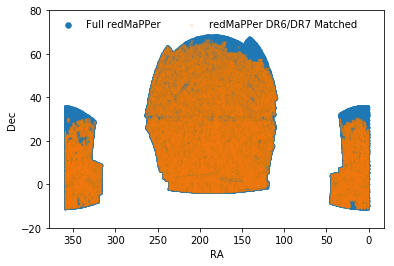

In [14]:
fig, ax = plt.subplots()
ax.scatter(rmcenall['RA_SDSS'], rmcenall['DEC_SDSS'], s=1, label='Full redMaPPer')
ax.scatter(rmcen['RA_SDSS'], rmcen['DEC_SDSS'], s=1, alpha=0.1, 
           marker='.', label='redMaPPer DR6/DR7 Matched')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_ylim(-20, 80)
ax.invert_xaxis()
lgnd = ax.legend(loc='upper left', frameon=False, fontsize=10, ncol=2)
for ll in lgnd.legendHandles:
    ll._sizes = [30]

### Satellites

In [15]:
lssatall = read_legacysurvey(lsdr=lsdr, rmversion=rmversion, satellites=True)
satmatched = np.where( 
    (lssatall['GALDEPTH_G'] > 0) * 
    (lssatall['GALDEPTH_R'] > 0) * 
    (lssatall['GALDEPTH_Z'] > 0) )[0]
print('Identified {} satellites with grz photometry and a match to redMaPPer.'.format(len(satmatched)))
lssat = lssatall[satmatched]
#lssat

Read 10735182 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/legacysurvey-dr6-dr7-members-v6.3.1-lgt5.fits
Identified 8731645 satellites with grz photometry and a match to redMaPPer.


In [16]:
rmsatall = read_redmapper(rmversion=rmversion, satellites=True)
assert(len(rmsatall) == len(lssatall))
rmsat = rmsatall[satmatched]
#rmsat

Read 10735182 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog_members.fit
Read 10735182 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/redmapper-v6.3.1-lgt5-members-sdssWISEphot-dr14.fits


### Additional sample cuts

Exclude the sources with the shallowest DR6/DR7 *grz* photometry (point-source depth).

In [17]:
band = ['G', 'R', 'Z']
targdepth = [24.0, 23.4, 22.5] # target 5-sigma depth
meddepth, p10depth = np.zeros((3)), np.zeros((3))

g depth: P10: 24.003, median = 24.501, target = 24.000
r depth: P10: 23.511, median = 24.002, target = 23.400
z depth: P10: 22.799, median = 23.212, target = 22.500


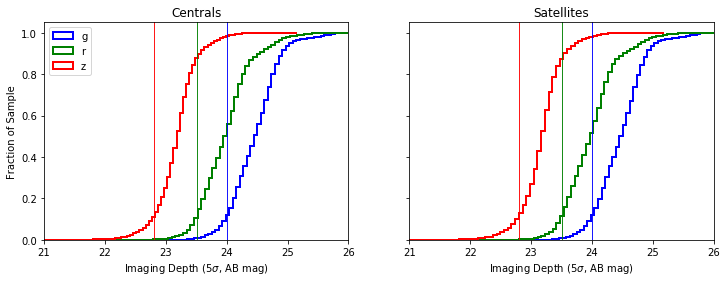

In [18]:
color = ('blue', 'green', 'red')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ii, (tt, bb, col) in enumerate( zip( targdepth, band, color ) ):
    cendepth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(lscen['PSFDEPTH_{}'.format(bb)]) )
    satdepth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(lssat['PSFDEPTH_{}'.format(bb)]) )
    
    meddepth[ii] = np.percentile(cendepth, [50])
    p10depth[ii] = np.percentile(cendepth, [10])
    print('{} depth: P10: {:.3f}, median = {:.3f}, target = {:.3f}'.format(
        bb.lower(), p10depth[ii], meddepth[ii], tt))
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # centrals
        nn, bins, patches = ax1.hist(cendepth, bins=100, histtype='step', cumulative=True,
                                     label=bb.lower(), normed=True, color=col, lw=2)
        patches[0].set_xy(patches[0].get_xy()[:-1]) # delete the last point
        # satellites
        nn, bins, patches = ax2.hist(satdepth, bins=100, histtype='step', cumulative=True,
                                     label=bb.lower(), normed=True, color=col, lw=2)
        patches[0].set_xy(patches[0].get_xy()[:-1]) # delete the last point
    
    #ax.axvline(x=tt, ls='--', color=col, lw=2, alpha=1.0)
    #ax.axvline(x=meddepth[ii], ls='-', color=col, lw=1, alpha=0.9)
    for ax in (ax1, ax2):
        ax.axvline(x=p10depth[ii], ls='-', color=col, lw=1, alpha=0.9)

ax1.legend(loc='upper left')
ax1.set_ylabel('Fraction of Sample')
ax1.set_title('Centrals')
ax2.set_title('Satellites')
for ax in (ax1, ax2):
    ax.set_xlabel('Imaging Depth (5$\sigma$, AB mag)')
    ax.set_xlim(21, 26)
    
fig.subplots_adjust(hspace=0.01)

In [19]:
cendepthcut = np.ones(len(lscen)).astype(bool)
satdepthcut = np.ones(len(lssat)).astype(bool)
for ii, bb in enumerate(['G', 'R', 'Z']):
    cendepth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(lscen['PSFDEPTH_{}'.format(bb)]) )
    satdepth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(lssat['PSFDEPTH_{}'.format(bb)]) )
    cendepthcut *= cendepth > p10depth[ii]
    satdepthcut *= satdepth > p10depth[ii]
print('{} / {} ({:.2f}%) centrals pass the depth cuts in all three bands.'.format(
    np.sum(cendepthcut), len(lscen), 100*np.sum(cendepthcut)/len(lscen)))
print('{} / {} ({:.2f}%) satellites pass the depth cuts in all three bands.'.format(
    np.sum(satdepthcut), len(lssat), 100*np.sum(satdepthcut)/len(lssat)))

266218 / 348212 (76.45%) centrals pass the depth cuts in all three bands.
6682618 / 8731645 (76.53%) satellites pass the depth cuts in all three bands.


### Cut and join the redMaPPer (central & satellite) and LS catalogs

In [20]:
rmcendeep = rmcen[cendepthcut]
lscendeep = lscen[cendepthcut]
cen = hstack( (rmcendeep, lscendeep) )

In [21]:
sat = hstack( (rmsat[satdepthcut], lssat[satdepthcut]) )

In [22]:
def _normhist(xx, ax, label=None, alpha=1.0, lw=2, bins=100):
    _, _, _ = ax.hist(xx, weights=np.ones_like(xx) / float(len(xx)), 
                      bins=bins, histtype='step', label=label,
                      lw=lw, alpha=alpha)

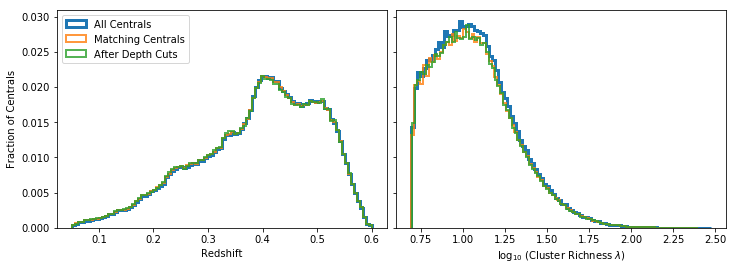

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

_normhist(rmcenall['Z'], ax1, label='All Centrals', lw=3)
_normhist(rmcen['Z'], ax1, label='Matching Centrals', alpha=0.8)
_normhist(rmcendeep['Z'], ax1, label='After Depth Cuts', alpha=0.8)
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Fraction of Centrals')
ax1.legend(loc='upper left')

_normhist(np.log10(rmcenall['LAMBDA_CHISQ']), ax2, lw=3)
_normhist(np.log10(rmcen['LAMBDA_CHISQ']), ax2, alpha=0.8)
_normhist(np.log10(rmcendeep['LAMBDA_CHISQ']), ax2, alpha=0.8)
ax2.set_xlabel('$\log_{10}$ (Cluster Richness $\lambda$)')
#ax2.set_ylabel('Fraction of Galaxies')
fig.subplots_adjust(wspace=0.03)

### Get the total area subtended by the final sample.

In [24]:
def get_area(nside=256, qaplot=True):
    """Get the unique area of the sample."""
    
    areaperpix = hp.nside2pixarea(nside, degrees=True)
    samplepix = radec2pix(nside, cen['RA'].data, cen['DEC'].data)

    outpixmap = []
    for dr, release in zip( ('dr6.0', 'dr7.1'), (6000, 7000) ):
        # Read the pixel weight map which quantifies the imaging footprint
        pixfile = os.path.join( legacyhalos.io.sample_dir(), 'pixweight-{}-0.22.0.fits'.format(dr) )
        pixmap = Table(fitsio.read(pixfile))
        pixmap['DR'] = dr.upper()
    
        these = cen['RELEASE'].data == release
        thesepix = np.unique(samplepix[these])
    
        # Only keep non-empty healpixels.
        keep = ( (pixmap['FRACAREA'][thesepix] > 0) * 
                (pixmap['PSFDEPTH_G'][thesepix] > 0) * # p10depth[0]) * 
                (pixmap['PSFDEPTH_R'][thesepix] > 0) * # p10depth[1]) * 
                (pixmap['PSFDEPTH_Z'][thesepix] > 0)   # p10depth[2]) 
               )
        outpixmap.append(pixmap[thesepix][keep])
    outpixmap = vstack(outpixmap)
    
    if False:
        print('Clamping FRACAREA at unity!')
        toobig = outpixmap['FRACAREA'] > 1
        if np.sum(toobig) > 0:
            outpixmap['FRACAREA'][toobig] = 1.0

    # Don't double-count area, where DR6 and DR7 overlap.
    _, keep = np.unique(outpixmap['HPXPIXEL'], return_index=True)
    dup = np.delete( np.arange(len(outpixmap)), keep )
    
    # Code to double-check for duplicates and to ensure every object 
    # has been assigned a healpixel.
    # for pp in outpixmap['HPXPIXEL'][keep]:
    #     if np.sum( pp == outpixmap['HPXPIXEL'][keep] ) > 1:
    #         print('Duplicate!')
    #         import pdb ; pdb.set_trace()
    #     if np.sum( pp == samplepix ) == 0:
    #         print('Missing healpixel!')
    #         import pdb ; pdb.set_trace()
    
    area = np.sum(outpixmap['FRACAREA'][keep]) * areaperpix
    duparea = np.sum(outpixmap['FRACAREA'][dup]) * areaperpix

    if qaplot:
        uu = np.in1d(samplepix, outpixmap['HPXPIXEL'][keep])
        dd = np.in1d(samplepix, outpixmap['HPXPIXEL'][dup])
        fig, ax = plt.subplots()
        ax.scatter(cen['RA'][uu], cen['DEC'][uu], s=1, marker='s',
                   label=r'Unique: {:.1f} deg$^{{2}}$'.format(area))
        ax.scatter(cen['RA'][dd], cen['DEC'][dd], s=1, marker='s',
                   label=r'Overlapping: {:.1f} deg$^{{2}}$'.format(duparea))
        ax.set_xlim(0, 360)
        ax.set_ylim(-15, 80)
        #ax.legend(loc='upper right', fontsize=12, frameon=False)
        ax.invert_xaxis()
        lgnd = ax.legend(loc='upper left', frameon=False, fontsize=10, ncol=2)
        for ll in lgnd.legendHandles:
            ll._sizes = [30]        
        
    return area, duparea, outpixmap[keep]

Unique area = 6717.906 deg2
Overlapping area = 21.661 deg2


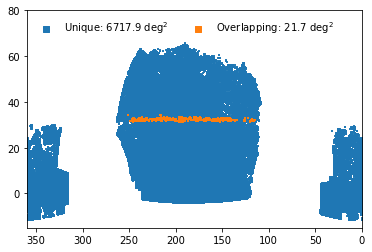

In [25]:
area, duparea, pixmap = get_area()
print('Unique area = {:.3f} deg2\nOverlapping area = {:.3f} deg2'.format(area, duparea))

In [26]:
len(pixmap), len(np.unique(pixmap['HPXPIXEL']))

(129634, 129634)

### Create jackknife samples

In [27]:
def jackknife_samples(pixmap, nside_pixmap=256, nside_jack=4):
    """Split the sample into ~equal area chunks and write out a table.
    
    """
    from astropy.io import fits
    
    area_jack = hp.nside2pixarea(nside_jack, degrees=True)
    area_pixmap = hp.nside2pixarea(nside_pixmap, degrees=True)
    print('Jackknife nside = {} with area = {:.3f} deg2'.format(nside_jack, area_jack))
    
    pix_jack = radec2pix(nside_jack, cen['RA'].data, cen['DEC'].data)
    pix_pixmap = radec2pix(nside_pixmap, cen['RA'].data, cen['DEC'].data)
    
    upix_jack = np.unique(pix_jack)
    upix_jack = upix_jack[np.argsort(upix_jack)]
    npix = len(upix_jack)
    
    ra_jack, dec_jack = pix2radec(nside_jack, upix_jack)
    
    out = Table()
    out['HPXPIXEL'] = upix_jack
    out['RA'] = ra_jack
    out['DEC'] = dec_jack
    out['AREA'] = np.zeros(npix).astype('f4')
    out['NCEN'] = np.zeros(npix).astype('int')
    
    for ii, pp in enumerate(upix_jack):
        these = np.where( pp == pix_jack )[0]
        indx = np.where( np.in1d( pixmap['HPXPIXEL'].data, pix_pixmap[these] ) )[0]
        uindx = np.unique(indx)
        #print(pp, len(indx), len(uindx))

        out['AREA'][ii] = np.sum(pixmap['FRACAREA'][indx].data) * area_pixmap
        out['NCEN'][ii] = len(these)
        
        #if ii == 4:
        #    rbig, dbig = pix2radec(nside_jack, pp)
        #    rsmall, dsmall = pix2radec(nside_pixmap, pixmap['HPXPIXEL'][indx].data)
        #    rgal, dgal = sample['RA'][these], sample['DEC'][these]
        #    plt.scatter(rgal, dgal, s=3, marker='o', color='green')
        #    plt.scatter(rsmall, dsmall, s=3, marker='s', color='blue')
        #    plt.scatter(rbig, dbig, s=75, marker='x', color='k')
        #    plt.show()
        #    import pdb ; pdb.set_trace() 
        
    print('Writing {}'.format(jackfile))
    hx = fits.HDUList()
    hdu = fits.convenience.table_to_hdu(out)
    hdu.header['EXTNAME'] = 'JACKKNIFE'
    hdu.header['NSIDE'] = nside_jack
    hx.append(hdu)
    hx.writeto(jackfile, overwrite=True)

    return out

In [28]:
nside_jack = 4
jack = jackknife_samples(pixmap, nside_jack=nside_jack)
njack = len(jack)
jack

Jackknife nside = 4 with area = 214.859 deg2
Writing /Users/ioannis/research/projects/legacyhalos/sample/legacyhalos-jackknife-dr6-dr7.fits


HPXPIXEL,RA,DEC,AREA,NCEN
int64,float64,float64,float32,int64
0,45.0,9.59406822686,11.5617,444
2,33.75,19.4712206345,24.1257,902
8,22.5,30.0,24.8378,941
16,135.0,9.59406822686,168.981,6969
17,146.25,19.4712206345,171.401,7071
18,123.75,19.4712206345,126.593,4514
19,135.0,30.0,130.081,4864
20,157.5,30.0,149.366,5582
21,168.75,41.8103148958,139.298,5052


Check: total area = 6717.906, total number of galaxies = 266218
Mean / median area per pixel = 89.572 / 91.775 deg2
Mean / median number of centrals per pixel = 3550 / 3712


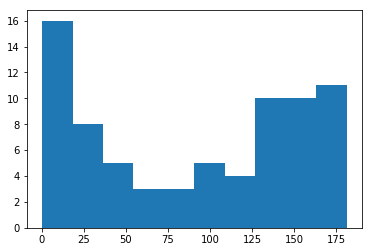

In [29]:
print('Check: total area = {:.3f}, total number of galaxies = {}'.format(
    np.sum(jack['AREA']), np.sum(jack['NCEN'])))
print('Mean / median area per pixel = {:.3f} / {:.3f} deg2'.format(
    np.mean(jack['AREA']), np.median(jack['AREA'])))
print('Mean / median number of centrals per pixel = {:.0f} / {:.0f}'.format(
    np.mean(jack['NCEN']), np.median(jack['NCEN'])))
_ = plt.hist(jack['AREA'])

Visualize the jackknife samples.

Text(0,0.5,'Dec')

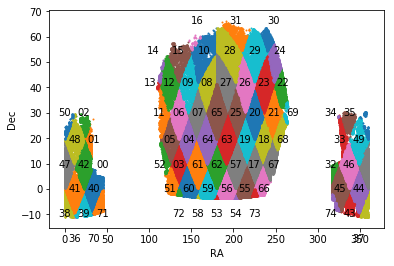

In [30]:
jackpix = legacyhalos.misc.radec2pix(nside_jack, cen['RA'].data, cen['DEC'].data)
jack_ra, jack_dec = legacyhalos.misc.pix2radec(nside_jack, jack['HPXPIXEL'])
fig, ax = plt.subplots()
for ii in range(njack):
    indx = np.where( jack['HPXPIXEL'][ii] == jackpix )[0]
    ax.scatter(cen['RA'][indx], cen['DEC'][indx], s=1)
    ax.text(jack_ra[ii], jack_dec[ii], '{:02d}'.format(ii), 
            va='center', ha='center')
    #ax.text(jack_ra[ii], jack_dec[ii], '{:02d}'.format(jack['HPXPIXEL'][ii]))    
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

### Write out the final samples.

In [31]:
print('Writing {}'.format(cenfile))
cen.write(cenfile, overwrite=True)

Writing /Users/ioannis/research/projects/legacyhalos/sample/legacyhalos-centrals-dr6-dr7.fits


In [32]:
print('Writing {}'.format(satfile))
sat.write(satfile, overwrite=True)

Writing /Users/ioannis/research/projects/legacyhalos/sample/legacyhalos-satellites-dr6-dr7.fits


In [33]:
sat

CENTRAL_ID,MEM_MATCH_ID,SDSS_OBJID,ID,RA_SDSS,DEC_SDSS,PETROMAGGIES [5],PETROMAGGIES_IVAR [5],MODELMAGGIES [5],MODELMAGGIES_IVAR [5],CMODELMAGGIES [5],CMODELMAGGIES_IVAR [5],WISE_NANOMAGGIES [2],WISE_NANOMAGGIES_IVAR [2],EXTINCTION [5],PETROR50 [5],Z,RA_REDMAPPER,DEC_REDMAPPER,R,P,PFREE,THETA_I,THETA_R,MODEL_MAG [5],MODEL_MAGERR [5],IMAG,IMAG_ERR,ZRED,ZRED_E,ZRED2,ZRED2_E,CHISQ,ZSPEC,PHOTOID,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,BRIGHTSTARINBLOB,PHOTSYS
str7,int32,int64,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bytes1
0010235,10235,1237645879562862749,11,15.9074591418,1.27291782975,2.49176 .. 61.3125,1.23573 .. 0.0555574,1.34552 .. 66.1198,6.14315 .. 0.221715,3.33857 .. 64.8088,1.84596 .. 0.184375,858.026 .. 1144.84,0.00263683 .. 0.000203664,0.100113 .. 0.0298286,2.73135 .. 1.13265,0.191878,15.9074567908,1.27291866953,0.482201,0.871072,1.0,1.0,1.0,22.0679 .. 17.9067,0.319857 .. 0.0348654,18.3135,0.0132415,0.183903,0.0103617,0.182269,0.0103585,1.98725,-1.0,940301602740157,7000,482594,2399p272,1916,COMP,239.852363375,27.2168561398,1.90359e+13,3.80733e+13,2.26807e+06 .. 4.1777e+06,0.0420742,143.776,368.841,739.902,677.782,421.449,145.235,-62.0267,29.8283,11.7531,3.61937,2.12858,0.439642,0.0018931,2.49718e-05,0.882896,0.919525,0.954156,0.992895,0.995631,0.999067,0.999647,2,2,2,0.00235617,0.00351817,0.0021695,0.031506,0.0332716,0.0314223,0.663683,0.653012,0.665028,0,0,0,1094.75,353.791,126.04,697.248,240.718,58.2428,0.760629,4.40691e+06,4.83357,111222.0,-0.430467,1.97129e+06,0.0748336,1.32459e+06,1.10243,341772.0,0.0787034,470184.0,-0.158541,631934.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,24.7364,63.4582,127.299,24.7364,63.4582,127.299,False,
0010235,10235,1237645879562863131,13,15.9132616094,1.27350995779,1.13294 .. 50.2362,1.03674 .. 0.0460227,0.906861 .. 49.2081,4.84718 .. 0.185502,7.11273 .. 59.8358,0.212422 .. 0.0689626,655.416 .. 709.249,0.00252423 .. 0.000197054,0.100143 .. 0.0298373,1.09425 .. 1.41455,0.191878,15.9132593356,1.27351074761,0.50851,0.829652,1.0,1.0,0.99999